In [18]:
import yaml
import torch

from roadvision3d.src.engine.model_builder import build_model
from roadvision3d.src.engine.model_saver import load_checkpoint
from roadvision3d.tools.inference import inference, process_image
from roadvision3d.src.datasets.object_3d import Calibration
from roadvision3d.visualization import Visualizer
from roadvision3d.src.datasets.object_3d import get_affine_transform


from PIL import Image
import numpy as np
from torchvision.io import read_video
import matplotlib.pyplot as plt

import pickle


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
def video_to_frames_pytorch(video_path, device='cuda:0'):
    """
    Extracts frames from a video using TorchVision and returns them as a tensor on the specified device.
    
    Parameters:
    video_path (str): Path to the input video file.
    device (str): 'cuda' for GPU or 'cpu' for CPU processing.

    Returns:
    torch.Tensor: A tensor containing video frames in (num_frames, height, width, channels) format.
    """
    # Load video using TorchVision
    video_frames, _, _ = read_video(video_path, pts_unit='sec')
    
    # Move frames to specified device
    video_frames = video_frames.to(device)
    
    print(f"Loaded video with {video_frames.shape[0]} frames.")
    
    return video_frames

In [20]:
video_path = '/home/javier/pytorch/RoadVision3D/roadvision3d/data/delicias3_x1_30fps.mp4'

frames = video_to_frames_pytorch(video_path, device='cuda:1')

Loaded video with 579 frames.


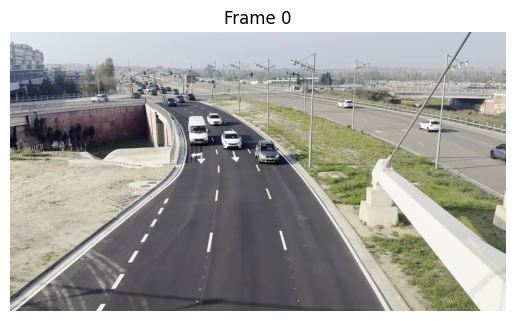

In [21]:
# Extract the specified frame and move it to CPU
frame = frames[0].cpu()

# Transpose dimensions to (height, width, channels) for display

# Display the frame
plt.imshow(frame.int())
plt.axis('off')
plt.title(f"Frame {0}")
plt.show()

In [22]:
shorted_video = frames[:30]


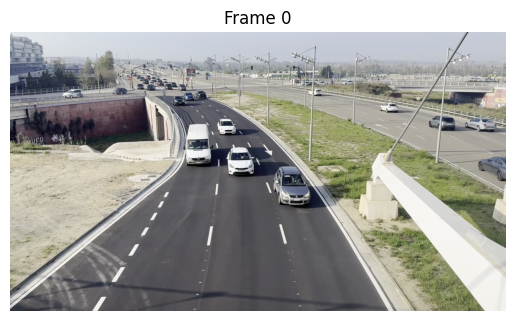

In [23]:
# Extract the specified frame and move it to CPU
frame = shorted_video[29].cpu()

# Transpose dimensions to (height, width, channels) for display

# Display the frame
plt.imshow(frame.int())
plt.axis('off')
plt.title(f"Frame {0}")
plt.show()

In [24]:
def inference_video(video, calib, model, cfg, device='cuda:0'):
    """
    Perform inference on a video using the specified model and calibration data.
    
    Parameters:
    video (torch.Tensor): A tensor containing video frames in (num_frames, height, width, channels) format.
    calib (roadvision3d.src.datasets.object_3d.Calibration): Calibration data for the video.
    model (torch.nn.Module): A PyTorch model to use for inference.
    device (str): 'cuda' for GPU or 'cpu' for CPU processing.

    Returns:
    list: A list of dictionaries containing the predicted objects for each frame.
    """
    # Initialize list to store predictions
    predictions = []
    
    # Move model to specified device
    model = model.to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    # Iterate over video frames
    for i in range(video.shape[0]):
        # Extract frame and move it to specified device
        frame = video[i]
        # Convertir el frame a NumPy
        frame_numpy = frame.cpu().numpy()

        img_tensor, coord = process_frame(frame_numpy, cfg)
        
        # Perform inference on the frame
        results = inference(img_tensor, calib, model, cfg, device, coord)
        
        # Append prediction to list
        predictions.append(results)
        
        print(f"Processed frame {i + 1}/{video.shape[0]}.")
    
    return predictions

def process_frame(frame, cfg):
    raw_img = Image.fromarray(frame)
    img_size = np.array(raw_img.size)

    img_resolution = np.array(cfg['dataset']['resolution'])
    # statistics
    mean = np.array(cfg['dataset']['mean'], dtype=np.float32)
    std  = np.array(cfg['dataset']['std'], dtype=np.float32)

    center = np.array(img_size) / 2
    crop_size = img_size

    trans, trans_inv = get_affine_transform(center, crop_size, 0, img_resolution, inv=1)

    img_rescaled = raw_img.transform(tuple(img_resolution.tolist()),
                            method=Image.AFFINE,
                            data=tuple(trans_inv.reshape(-1).tolist()),
                            resample=Image.BILINEAR)

    # image encoding
    img = np.array(img_rescaled).astype(np.float32) / 255.0
    img = (img - mean) / std
    img = img.transpose(2, 0, 1)  # C * H * W

    img_tensor = torch.from_numpy(img)

    # Ensure the tensor is of the correct dtype (float32) and device (CPU or CUDA)
    img_tensor = img_tensor.float().unsqueeze(0)  # Ensures tensor is in float32, if not already

    coord_range = torch.from_numpy(np.array([center-crop_size/2,center+crop_size/2]).astype(np.float32)).float()


    return img_tensor, coord_range

In [25]:
config_path = '/home/javier/pytorch/RoadVision3D/roadvision3d/configs/MonoLSS_DAIR_150e.yaml'
checkpoint_path = '/home/javier/pytorch/RoadVision3D/work_dirs/MonoLSS_DAIR_150e_valid/logs/checkpoints/checkpoint_epoch_150.pth'

cfg = yaml.load(open(config_path, 'r'), Loader=yaml.Loader)    
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

model = build_model(cfg)
load_checkpoint(model = model,
                optimizer = None,
                filename = checkpoint_path,
                map_location=device)

150

In [26]:
# Función para cargar un archivo PKL
def cargar_pkl(ruta):
    with open(ruta, 'rb') as archivo:
        return pickle.load(archivo)

calib_path = '/home/javier/pytorch/RoadVision3D/roadvision3d/data/iPhone_16_Pro_calib.pkl'
calib_file = cargar_pkl(calib_path)

print(calib_file)

calib_matrix = calib_file['calib_1']['camera_matrix']

print(calib_matrix)

calib = Calibration.from_intrinsic_matrix(calib_matrix)

{'calib_05': {'camera_matrix': array([[875.87988717,   0.        , 963.17817063],
       [  0.        , 874.94957869, 539.95067275],
       [  0.        ,   0.        ,   1.        ]]), 'dist_calib': array([[-0.03367494,  0.02943681, -0.00026326,  0.00217389, -0.00364975]]), 'undistorted_camera_matrix': array([[872.1669888 ,   0.        , 969.56388662],
       [  0.        , 863.72606215, 539.60829155],
       [  0.        ,   0.        ,   1.        ]])}, 'calib_1': {'camera_matrix': array([[1.61434549e+03, 0.00000000e+00, 9.72495356e+02],
       [0.00000000e+00, 1.61147802e+03, 5.37840876e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]), 'dist_calib': array([[ 0.0963433 ,  0.05252466, -0.00145468,  0.00451231, -0.80605149]]), 'undistorted_camera_matrix': array([[1.53155723e+03, 0.00000000e+00, 1.00063118e+03],
       [0.00000000e+00, 1.49895307e+03, 5.34018597e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])}, 'calib_5': {'camera_matrix': array([[7.64186

In [27]:
results_video = inference_video(frames, calib, model, cfg, device=device)

Processed frame 1/579.
Processed frame 2/579.
Processed frame 3/579.
Processed frame 4/579.
Processed frame 5/579.
Processed frame 6/579.
Processed frame 7/579.
Processed frame 8/579.
Processed frame 9/579.
Processed frame 10/579.
Processed frame 11/579.
Processed frame 12/579.
Processed frame 13/579.
Processed frame 14/579.
Processed frame 15/579.
Processed frame 16/579.
Processed frame 17/579.
Processed frame 18/579.
Processed frame 19/579.
Processed frame 20/579.
Processed frame 21/579.
Processed frame 22/579.
Processed frame 23/579.
Processed frame 24/579.
Processed frame 25/579.
Processed frame 26/579.
Processed frame 27/579.
Processed frame 28/579.
Processed frame 29/579.
Processed frame 30/579.
Processed frame 31/579.
Processed frame 32/579.
Processed frame 33/579.
Processed frame 34/579.
Processed frame 35/579.
Processed frame 36/579.
Processed frame 37/579.
Processed frame 38/579.
Processed frame 39/579.
Processed frame 40/579.
Processed frame 41/579.
Processed frame 42/579.
P

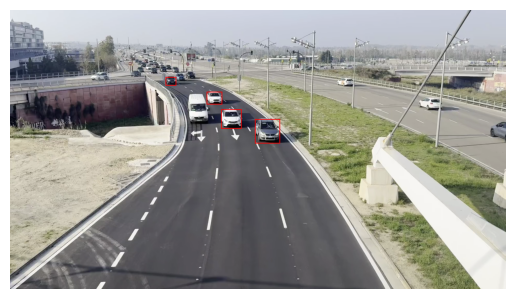

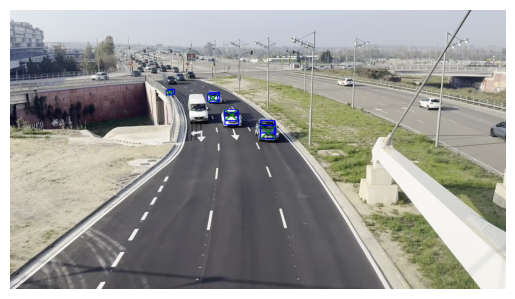

In [28]:
visualizer = Visualizer(calib=calib, pitch=0.22)

index = 0

frame_numpy = shorted_video[index].cpu().numpy()

pil_img = Image.fromarray(frame_numpy)

# Draw 2D bounding boxes on the image
image_with_2d = visualizer.draw_2d_bboxes(pil_img, results_video[index], color='red', width=3, display=True)

# Draw 3D bounding boxes on the image
image_with_3d = visualizer.draw_3d_bboxes(pil_img, results_video[index], color='blue', color_front='green', width=4, display=True)

In [29]:
def create_results_frames(frames, results, calib):
    visualizer = Visualizer(calib=calib, pitch=0.22)
    results_2d_video = []
    results_3d_video = []

    for frame, result in zip(frames, results):
        frame_numpy = frame.cpu().numpy()
        pil_img = Image.fromarray(frame_numpy)
        image_with_2d = visualizer.draw_2d_bboxes(pil_img, result, color='red', width=3, display=False)
        image_with_3d = visualizer.draw_3d_bboxes(pil_img, result, color='blue', color_front='green', width=4, display=False)
        results_2d_video.append(image_with_2d)
        results_3d_video.append(image_with_3d)

    return results_2d_video, results_3d_video
    
result_frames_2d, result_frames_3d = create_results_frames(frames, results_video, calib)

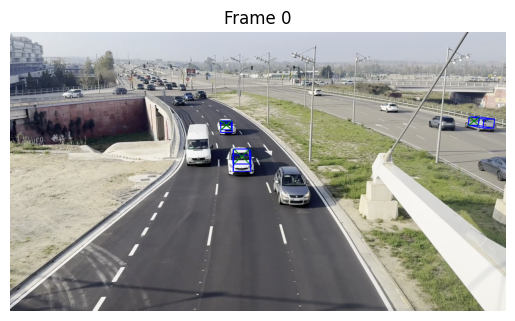

In [30]:
# Extract the specified frame and move it to CPU
frame = result_frames_3d[29]

# Transpose dimensions to (height, width, channels) for display

# Display the frame
plt.imshow(frame)
plt.axis('off')
plt.title(f"Frame {0}")
plt.show()

In [31]:
import cv2

def frames_to_video_mp4(pil_images, output_path="output_video.mp4", fps=30):
    """
    Saves an array of PIL images directly to an MP4 video file without using temporary image files.

    Parameters:
    pil_images (list of PIL.Image): List containing frames as PIL images.
    output_path (str): Path to save the output video, should end with .mp4 for MP4 format.
    fps (int): Frames per second for the output video.
    """
    if len(pil_images) == 0:
        raise ValueError("The input list of images is empty.")

    # Get frame dimensions from the first image
    width, height = pil_images[0].size

    # Define the codec and create VideoWriter object for MP4 format
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' codec for .mp4 files
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Write each PIL image to the video
    for img in pil_images:
        # Convert PIL image to NumPy array
        frame_np = np.array(img)

        # Convert RGB to BGR for OpenCV
        frame_bgr = cv2.cvtColor(frame_np, cv2.COLOR_RGB2BGR)
        
        # Write the frame to the video
        out.write(frame_bgr)

    # Release the VideoWriter object
    out.release()
    print(f"Video saved to {output_path}")

out_dir_2d = '/home/javier/pytorch/RoadVision3D/notebooks/video_2d.mp4'
out_dir_3d = '/home/javier/pytorch/RoadVision3D/notebooks/video_3d.mp4'
frames_to_video_mp4(result_frames_2d, output_path=out_dir_2d, fps=30)
frames_to_video_mp4(result_frames_3d, output_path=out_dir_3d, fps=30)

Video saved to /home/javier/pytorch/RoadVision3D/notebooks/video_2d.mp4
Video saved to /home/javier/pytorch/RoadVision3D/notebooks/video_3d.mp4
